## Установка зависимостей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## Описание данных

Файлы данных train.csv и test.csv содержат изображения в оттенках серого, нарисованные от руки цифры от нуля до девяти.

Каждое изображение имеет высоту 28 пикселей и ширину 28 пикселей, что в сумме составляет 784 пикселя. Каждому пикселю соответствует одно значение, указывающее на его светлую или тёмную насыщенность: чем больше число, тем темнее. Значение представляет собой целое число от 0 до 255 включительно.

Обучающий набор данных (train.csv) содержит 785 столбцов. Первый столбец, называемый «label», содержит цифру, нарисованную пользователем. Остальные столбцы содержат значения пикселей соответствующего изображения.

Каждый столбец пикселей в обучающем наборе имеет имя, например, pixelx, где x — целое число от 0 до 783 включительно. Чтобы найти этот пиксель на изображении, предположим, что мы разложили x следующим образом: x = i * 28 + j, где i и j — целые числа от 0 до 27 включительно. Тогда пиксель x находится в строке i и столбце j матрицы размером 28 x 28 (индексация начинается с нуля).

Например, pixel31 указывает пиксель, который находится в четвертом столбце слева и во второй строке сверху, как на диаграмме ASCII ниже.

Визуально, если опустить префикс «пиксель», пиксели составляют изображение следующим образом:

## Загрузка и анализ данных

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
train["label"].head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [4]:
y = train["label"]
X = train.drop("label", axis=1)
X_test = test

In [5]:
y.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

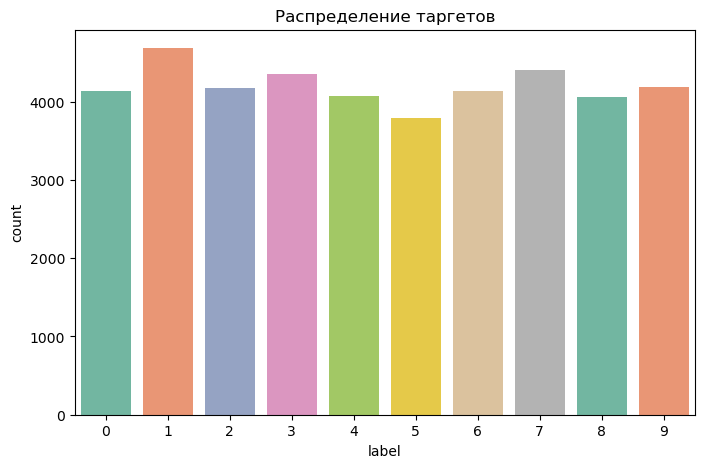

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=train,
    x="label",
    hue="label",
    palette="Set2",
    legend=False
)
plt.title("Распределение таргетов")

plt.show()

Кол-во элементов на каждый класс примерно одинаковое

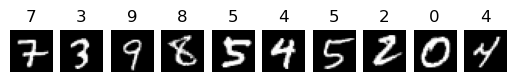

In [7]:
idxs = np.random.choice(len(X), 10, replace=False)

for i, idx in enumerate(idxs):
    plt.subplot(1, 10, i+1)
    plt.imshow(X.values.reshape(-1,28,28,1)[idx], cmap="gray")
    plt.title(y[idx])
    plt.axis("off")
plt.show()

## Пайплайн для классических моделей

Посмотрим, как с задачей справятся классические модели.
Проверим градиентные бустинги (Catboost и XGBoost) и прогоним через GridSearch стохастический градиентный спуск и случайный лес.

In [8]:
# Разделение на тренировочную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_val.shape}")

Размер тренировочной выборки: (33600, 784)
Размер тестовой выборки: (8400, 784)


In [9]:
results = {}

# ==== XGBoost ====

xgboost_model = XGBClassifier(
    random_state=42,
    n_estimators=2000,
    learning_rate=0.1,
    early_stopping_rounds=50,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbose=100
)
xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
y_pred = xgboost_model.predict(X_val)
xgboost_score = accuracy_score(y_val, y_pred)

xgboost_model.save_model("../models/xgboost_model.json")

print(f"Accuracy XGBoost: {xgboost_score:.4f}")

Accuracy XGBoost: 0.9752


In [21]:
results["xgboost"] = {
            "model": xgboost_model,
            "score": xgboost_score
        }

In [11]:
# ==== CatBoost ====

catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=3000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    early_stopping_rounds=50,
    verbose=100,
)
catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred = catboost_model.predict(X_val)
catboost_score = accuracy_score(y_val, y_pred)

catboost_model.save_model("../models/catboost_model.cbm")

print(f"Accuracy CatBoost: {catboost_score:.4f}")

0:	learn: 1.9939983	test: 1.9983333	best: 1.9983333 (0)	total: 270ms	remaining: 13m 29s
100:	learn: 0.1978026	test: 0.2222361	best: 0.2222361 (100)	total: 32.2s	remaining: 15m 23s
200:	learn: 0.1428302	test: 0.1719118	best: 0.1719118 (200)	total: 1m 4s	remaining: 14m 58s
300:	learn: 0.1241802	test: 0.1574952	best: 0.1574952 (300)	total: 2m 2s	remaining: 18m 22s
400:	learn: 0.1115057	test: 0.1476312	best: 0.1476312 (400)	total: 3m 6s	remaining: 20m 6s
500:	learn: 0.1016798	test: 0.1407232	best: 0.1407232 (500)	total: 4m 8s	remaining: 20m 41s
600:	learn: 0.0948223	test: 0.1364967	best: 0.1364967 (600)	total: 5m 11s	remaining: 20m 44s
700:	learn: 0.0859677	test: 0.1302234	best: 0.1302162 (699)	total: 6m 15s	remaining: 20m 31s
800:	learn: 0.0788557	test: 0.1253184	best: 0.1253184 (800)	total: 7m 13s	remaining: 19m 50s
900:	learn: 0.0727766	test: 0.1212000	best: 0.1211913 (899)	total: 8m 4s	remaining: 18m 47s
1000:	learn: 0.0666856	test: 0.1173660	best: 0.1173660 (1000)	total: 9m 6s	remaini

In [22]:
results["catboost"] = {
            "model": catboost_model,
            "score": catboost_score
        }

In [18]:
# Создание параметров для кастомного GridSearch

param_grids = {
    "rf": {
        "n_estimators": [100, 300, 500],
        "max_depth": [5, 10, 20],
        "min_samples_leaf": [1, 3, 5]
    },
    "sgd": {
        "alpha": [1e-3, 1e-4],
        "loss": ["log_loss", "hinge"],
        "penalty": ["l2", "l1", "elasticnet"]
    }
}



In [19]:
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def gridsearch_custom(
        X_train, y_train,
        X_val, y_val,
        param_grids,
        batch_size=2048,
        epochs=5,
        verbose=True
    ):
    
    classes = np.unique(y_train)

    # Батчи
    n_batches = max(1, len(X_train) // batch_size)
    train_batches = np.array_split(X_train, n_batches)
    target_batches = np.array_split(y_train, n_batches)


    # ==== RANDOM FOREST ====
    if "rf" in param_grids:
        grid = param_grids["rf"]
        combinations = list(product(*grid.values()))

        best_score = 0
        best_params = None
        best_model = None

        if verbose:
            print("\n=== RandomForest ===")

        for comb in tqdm(combinations, desc="RF"):
            params = dict(zip(grid.keys(), comb))

            model = RandomForestClassifier(**params, random_state=42)
            model.fit(X_train, y_train)

            pred = model.predict(X_val)
            score = accuracy_score(y_val, pred)

            if score > best_score:
                best_score = score
                best_params = params
                best_model = model

        results["rf"] = {
            "model": best_model,
            "score": best_score,
            "params": best_params
        }
        print(f"RF: best score={best_score:.4f}, params={best_params}")


    # ==== SGDClassifier (батчи + эпохи) ====
    if "sgd" in param_grids:
        grid = param_grids["sgd"]
        combinations = list(product(*grid.values()))

        best_score = 0
        best_params = None
        best_model = None

        if verbose:
            print("\n=== SGDClassifier (батчи + эпохи) ===")

        for comb in tqdm(combinations, desc="SGD"):
            params = dict(zip(grid.keys(), comb))

            # каждый раз создаём новый SGD
            model = SGDClassifier(
                max_iter=1,           # мы полностью берём обучение под свой контроль
                warm_start=True,
                random_state=42,
                **params
            )

            # ---- Обучение эпохами ----
            for epoch in range(epochs):
                # перемешивание батчей (чтобы обучение было стабильнее)
                indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train.values[indices]
                y_train_shuffled = y_train.values[indices]

                batches_X = np.array_split(X_train_shuffled, n_batches)
                batches_y = np.array_split(y_train_shuffled, n_batches)

                for i, (X_b, y_b) in enumerate(zip(batches_X, batches_y)):
                    if epoch == 0 and i == 0:
                        model.partial_fit(X_b, y_b, classes=classes)
                    else:
                        model.partial_fit(X_b, y_b)

            # ---- Оценка ----
            pred = model.predict(X_val)
            score = accuracy_score(y_val, pred)

            if score > best_score:
                best_score = score
                best_params = params
                best_model = model

        results["sgd"] = {
            "model": best_model,
            "score": best_score,
            "params": best_params
        }
        print(f"SGD: best score={best_score:.4f}, params={best_params}")

    return results
    
results = gridsearch_custom(X_train, y_train,
        X_val, y_val,
        param_grids,
        batch_size=2048,
        epochs=5,
        verbose=True
)


=== RandomForest ===


RF: 100%|██████████████████████████████████████████████████████████████████████████████| 27/27 [15:09<00:00, 33.68s/it]


RF: best score=0.9663, params={'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 1}

=== SGDClassifier (батчи + эпохи) ===


SGD: 100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.89s/it]

SGD: best score=0.8931, params={'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l1'}


In [23]:
results

{'rf': {'model': RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42),
  'score': 0.9663095238095238,
  'params': {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 1}},
 'sgd': {'model': SGDClassifier(alpha=0.001, loss='log_loss', max_iter=1, penalty='l1',
                random_state=42, warm_start=True),
  'score': 0.893095238095238,
  'params': {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l1'}},
 'xgboost': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=50,
                enable_categorical=False, eval_metric='mlogloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
       

In [26]:
# Сравнение результатов всех моделей
print(f"\n{'='*50}")
print("ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"{'='*50}")

model_names = {
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost',
    'rf': 'Random Forest',
    'sgd': 'SGD'
}

for model_key, model_name in model_names.items():
    acc = results[model_key]['score']
    print(f"{model_name}: {acc:.4f}")

# Лучшая модель
best_model_key = max(results, key=lambda x: results[x]['score'])
best_model_name = model_names[best_model_key]
best_accuracy = results[best_model_key]['score']

print(f"\n{'='*50}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
if 'params' in results[best_model_key]:
    print(f"Параметры: {results[best_model_key]['params']}")

best_model = results[best_model_key]["model"]



ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ:
XGBoost: 0.9752
CatBoost: 0.9745
Random Forest: 0.9663
SGD: 0.8931

ЛУЧШАЯ МОДЕЛЬ: XGBoost
Accuracy: 0.9752


In [27]:
import joblib
joblib.dump(best_model, f"../models/{best_model_name}.pkl")

['../models/XGBoost.pkl']

In [32]:
# Лучшее предсказание для Kaggle среди классических моделей
final_predictions = best_model.predict(X_test)

# Submission
submission = pd.DataFrame({
    'ImageId': X_test.index + 1,
    'Label': final_predictions
})

submission.to_csv('../predictions/classic_final_submission.csv', index=False)

## Вывод по классическим моделям

Можем видеть, что среди используемых классических моделей лучший результат для данной задачи на валлидации показывают градиентые бустинги с  преимуществом на уровне погрешности у XGBoost. </br>
**Valid Accuracy:** 0.9752</br>
**Kaggle Score:** 0.97339

## Полносвязные NN

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [65]:
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.LongTensor(y_val.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

In [66]:
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Посмотрим какой результат мы получим у простой полносвязной модели, состоящей из 3 слоев и ReLU между ними.

In [46]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# Функция для обучения и оценки модели
def train_and_evaluate(model, train_loader, val_loader, 
                      model_name, num_epochs=50, learning_rate=0.001):
    print(f"\n=== ОБУЧЕНИЕ {model_name} ===")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Ранняя остановка
    best_val_acc = 0
    best_model_state = None
    patience = 10
    patience_counter = 0
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Валидация
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}')
        
        # Ранняя остановка
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch+1}")
            break
    
    # Загрузка лучшей модели
    model.load_state_dict(best_model_state)
    
    # Финальная оценка на тесте
    model.eval()
    test_correct = 0
    test_total = 0
    
    
    return model, best_val_acc, train_losses, val_accuracies

In [47]:
# Обучаем простой перцептрон
simple_model = SimpleMLP(hidden_size=512)
simple_model, simple_val_acc, simple_losses, simple_accs = train_and_evaluate(
    simple_model, train_loader, val_loader, "Простой перцептрон"
)


=== ОБУЧЕНИЕ Простой перцептрон ===
Epoch [1/50], Loss: 0.2935, Val Acc: 0.9505
Epoch [2/50], Loss: 0.1041, Val Acc: 0.9638
Epoch [3/50], Loss: 0.0618, Val Acc: 0.9649
Epoch [4/50], Loss: 0.0482, Val Acc: 0.9608
Epoch [5/50], Loss: 0.0305, Val Acc: 0.9631
Epoch [6/50], Loss: 0.0402, Val Acc: 0.9644
Epoch [7/50], Loss: 0.0568, Val Acc: 0.9650
Epoch [8/50], Loss: 0.0306, Val Acc: 0.9677
Epoch [9/50], Loss: 0.0168, Val Acc: 0.9713
Epoch [10/50], Loss: 0.0091, Val Acc: 0.9723
Epoch [11/50], Loss: 0.0078, Val Acc: 0.9685
Epoch [12/50], Loss: 0.0221, Val Acc: 0.9700
Epoch [13/50], Loss: 0.0167, Val Acc: 0.9707
Epoch [14/50], Loss: 0.0160, Val Acc: 0.9664
Epoch [15/50], Loss: 0.0107, Val Acc: 0.9717
Epoch [16/50], Loss: 0.0067, Val Acc: 0.9732
Epoch [17/50], Loss: 0.0153, Val Acc: 0.9665
Epoch [18/50], Loss: 0.0195, Val Acc: 0.9717
Epoch [19/50], Loss: 0.0184, Val Acc: 0.9631
Epoch [20/50], Loss: 0.0247, Val Acc: 0.9699
Epoch [21/50], Loss: 0.0086, Val Acc: 0.9715
Epoch [22/50], Loss: 0.0064

In [52]:
print(f"Валидация простой перцептрон: {simple_val_acc:.4f}")

Валидация простой перцептрон: 0.9763


Усложним модель, добавив dropout и batchnorm. Переберем параметры по сетке в поиске наилучших. 

In [42]:
class AdvancedModel(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, 
                 dropout_rate=0.3, use_batchnorm=True):
        super(AdvancedModel, self).__init__()
        layers_list = []
        
        # Первый слой
        layers_list.append(nn.Linear(input_size, hidden_sizes[0]))
        if use_batchnorm:
            layers_list.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers_list.append(nn.ReLU())
        
        # Скрытые слои
        for i in range(1, len(hidden_sizes)):
            layers_list.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if use_batchnorm:
                layers_list.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers_list.append(nn.ReLU())
            layers_list.append(nn.Dropout(dropout_rate * 0.8))
            
        # Выходной слой
        layers_list.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.network = nn.Sequential(*layers_list)

    def forward(self, x):
            return self.network(x)

# Функция для GridSearch продвинутой модели
def advanced_model_gridsearch():
    print("\n=== GRIDSEARCH ДЛЯ ПРОДВИНУТОЙ МОДЕЛИ ===")
    
    param_grid = {
        'hidden_sizes': [[512, 256]],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.0005],
        'use_batchnorm': [True]
    }
    
    best_val_acc = 0
    best_params = None
    best_model = None
    
    # Простой GridSearch
    from itertools import product
    
    for hidden_sizes, dropout_rate, lr, use_batchnorm in product(
        param_grid['hidden_sizes'],
        param_grid['dropout_rate'], 
        param_grid['learning_rate'],
        param_grid['use_batchnorm']
    ):
        print(f"\nПараметры: hidden_sizes={hidden_sizes}, dropout={dropout_rate}, lr={lr}, batchnorm={use_batchnorm}")
        
        model = AdvancedModel(
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate,
            use_batchnorm=use_batchnorm
        )
        
        model, val_acc,  _, _ = train_and_evaluate(
            model, train_loader, val_loader, 
            "Advanced Model", 
            num_epochs=50,
            learning_rate=lr
        )
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {
                'hidden_sizes': hidden_sizes,
                'dropout_rate': dropout_rate,
                'learning_rate': lr,
                'use_batchnorm': use_batchnorm
            }
            best_model = model
    
    print(f"\n🎉 ЛУЧШИЕ ПАРАМЕТРЫ: {best_params}")
    print(f"🎉 ЛУЧШАЯ ВАЛИДАЦИЯ: {best_val_acc:.4f}")
    
    return best_model, best_params, best_val_acc

# Запускаем GridSearch для продвинутой модели
advanced_model, best_params, advanced_val_acc = advanced_model_gridsearch()



=== GRIDSEARCH ДЛЯ ПРОДВИНУТОЙ МОДЕЛИ ===

Параметры: hidden_sizes=[512, 256], dropout=0.2, lr=0.0005, batchnorm=True

=== ОБУЧЕНИЕ Advanced Model ===
Epoch [1/50], Loss: 0.3409, Val Acc: 0.9532
Epoch [2/50], Loss: 0.1209, Val Acc: 0.9637
Epoch [3/50], Loss: 0.0729, Val Acc: 0.9631
Epoch [4/50], Loss: 0.0494, Val Acc: 0.9700
Epoch [5/50], Loss: 0.0364, Val Acc: 0.9715
Epoch [6/50], Loss: 0.0282, Val Acc: 0.9710
Epoch [7/50], Loss: 0.0205, Val Acc: 0.9712
Epoch [8/50], Loss: 0.0152, Val Acc: 0.9721
Epoch [9/50], Loss: 0.0154, Val Acc: 0.9712
Epoch [10/50], Loss: 0.0155, Val Acc: 0.9743
Epoch [11/50], Loss: 0.0149, Val Acc: 0.9719
Epoch [12/50], Loss: 0.0152, Val Acc: 0.9724
Epoch [13/50], Loss: 0.0132, Val Acc: 0.9752
Epoch [14/50], Loss: 0.0107, Val Acc: 0.9742
Epoch [15/50], Loss: 0.0105, Val Acc: 0.9744
Epoch [16/50], Loss: 0.0064, Val Acc: 0.9740
Epoch [17/50], Loss: 0.0046, Val Acc: 0.9746
Epoch [18/50], Loss: 0.0080, Val Acc: 0.9735
Epoch [19/50], Loss: 0.0086, Val Acc: 0.9718
Ep

## Вывод по полносвязным нейронным сетям

Можем заметить, что результат работы Полносвязных моделей не сильно отличается от результатов градиентного бустинга.

# CNN

In [76]:
# Преобразуем в float и нормализуем
X_train_tensor = torch.FloatTensor(X_train.values / 255.0).to(device)
X_val_tensor   = torch.FloatTensor(X_val.values / 255.0).to(device)
X_test_tensor  = torch.FloatTensor(X_test.values / 255.0).to(device)

# Тензоры меток
y_train_tensor = torch.LongTensor(y_train.values).to(device)
y_val_tensor   = torch.LongTensor(y_val.values).to(device)

In [77]:
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)
X_val_tensor   = X_val_tensor.view(-1, 1, 28, 28)
X_test_tensor  = X_test_tensor.view(-1, 1, 28, 28)

In [78]:
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Для теста
test_dataset  = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))  # метки не нужны
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 → 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14
            nn.ReLU(),
            nn.MaxPool2d(2)                              # → 7x7
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [80]:
simple_cnn = SimpleCNN().to(device)
simple_cnn, cnn_val_acc, _, _ = train_and_evaluate(
    simple_cnn, train_loader, val_loader, "CNN"
)




=== ОБУЧЕНИЕ CNN ===
Epoch [1/50], Loss: 0.4991, Val Acc: 0.9658
Epoch [2/50], Loss: 0.1430, Val Acc: 0.9782
Epoch [3/50], Loss: 0.1049, Val Acc: 0.9807
Epoch [4/50], Loss: 0.0847, Val Acc: 0.9818
Epoch [5/50], Loss: 0.0738, Val Acc: 0.9831
Epoch [6/50], Loss: 0.0599, Val Acc: 0.9849
Epoch [7/50], Loss: 0.0581, Val Acc: 0.9877
Epoch [8/50], Loss: 0.0479, Val Acc: 0.9883
Epoch [9/50], Loss: 0.0474, Val Acc: 0.9875
Epoch [10/50], Loss: 0.0404, Val Acc: 0.9896
Epoch [11/50], Loss: 0.0375, Val Acc: 0.9893
Epoch [12/50], Loss: 0.0334, Val Acc: 0.9890
Epoch [13/50], Loss: 0.0313, Val Acc: 0.9883
Epoch [14/50], Loss: 0.0285, Val Acc: 0.9888
Epoch [15/50], Loss: 0.0268, Val Acc: 0.9905
Epoch [16/50], Loss: 0.0238, Val Acc: 0.9889
Epoch [17/50], Loss: 0.0259, Val Acc: 0.9885
Epoch [18/50], Loss: 0.0230, Val Acc: 0.9905
Epoch [19/50], Loss: 0.0199, Val Acc: 0.9894
Epoch [20/50], Loss: 0.0190, Val Acc: 0.9895
Epoch [21/50], Loss: 0.0193, Val Acc: 0.9905
Epoch [22/50], Loss: 0.0174, Val Acc: 0.99

In [82]:
print(f"Валидация CNN: {cnn_val_acc:.4f}")

Валидация CNN: 0.9914


In [85]:
model.eval()
test_preds = []

with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = outputs.argmax(dim=1)
    test_preds.extend(preds.cpu().numpy())

submission = pd.DataFrame({
    "ImageId": range(1, len(test_preds) + 1),
    "Label": test_preds
})

submission.to_csv("../predictions/CNN_submission.csv", index=False)
print("CNN_submission.csv saved")



CNN_submission.csv saved


- **Valid Accuracy:** 0.9914
- **Kaggle Score:** 0.988

## Вывод по сверточным нейронным сетям

Как можем видеть, CNN улучшают результаты предсказаний. Вероятно, использовав более сложную сеть и аугментации, можно достигнуть еще более хороших результатов